### Introduction 
This is a code written along from the youtube tutorial https://www.youtube.com/watch?v=VMj-3S1tku0
In this tutorial, Andrej Karpathy introduces basics of neural networks and gradient descent by introducing simple Python library 
called "micrograd". This library implements a simple framework of modelling equations with multiple variables. It implements a concept of computational graph and allows to backtrack the derivatives of the output across all the parameters of the network.

In [59]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from draw_graph import visualize_graph
from value import Value

### Chain rule
This is the key concept in the backpropagation for nerual nets. Intuitively, it allows you to determine what is the impact of the change of one of the inner parameters of the equation (neural net) on the result. By calculating derivatives going "backward" from root node to the leafs, you can easily calcuate this impact of a small nibble in the input values using a chain rule.

Let's say we have an input a. b = a * 2, L = b + 2
In order to calculate dL/da, all you need to do is to find the intermediate derivatives along the way and multiply them.
dL/da = dL/db * db/da

According to chain rule, derivatives are also additives - i.e. if there exist many equations that involve a, then dL/da would be a sum of all derivatives of dx/da, where x-es are values that are function of a.
Example:
Input a. b = a * 2, c = a + 2, L = b + c
dL/da = dL/db * db/da + dL/dc * dc/da = 1 * 2 + 1 * 1 = 3

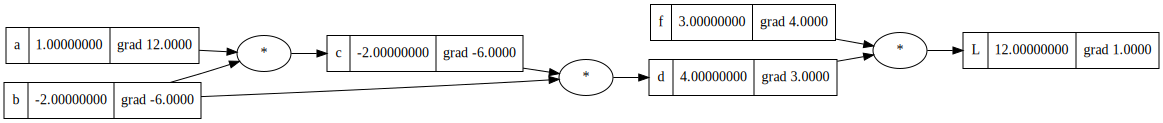

In [60]:
def fun(x):
    a = Value(x, label='a'); a.grad = 12 # dc/da = b = -2; dL/da = dc/da * dL/dc = -6 * -2 = 12
    b = Value(-2, label='b'); b.grad = -6 # dc/db = a = 1; dL/db = dL/dc * dc/db = -6 * 1 = -6
    c = a * b; c.label = 'c'; c.grad = -6 # dd/dc = b = -2; dL/dc = dL/dd * dd/dc = 3 * -2 = -6
    d = c * b; d.label = 'd'; d.grad = 3 # dL/dd = f = 3; check -> ((d+h)*f - d*f)/h = (df+fh-df)/h = f = 3
    f = Value(3, label='f'); f.grad = 4 # dL/df = d = 4
    L = d * f; L.label = 'L'; L.grad = 1
    return L

visualize_graph(fun(1.0))


In [61]:
# Verify the calculated derivative (gradient):
# dL/da = (f(a+h)-f(a))/h
h = 0.00001
L1, L2 = fun(1 + h), fun(1)
print((L2.val-L1.val)/h)

-12.000000000078613


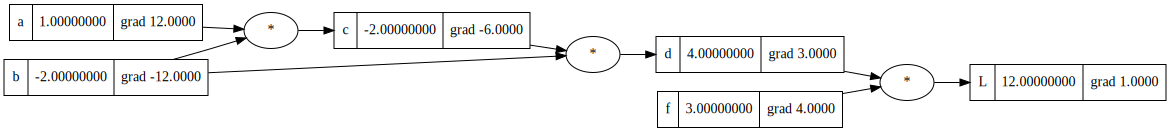

In [62]:
def fun_with_pow(x, h=0):
    a = Value(x, label='a') # dc/da = b = -2; dL/da = dc/da * dL/dc = -6 * -2 = 12
    b = Value(-2, label='b') # dc/db = a = 1; dd/db = c = -2; dL/db = (dL/dc * dc/db + dL/dd * dd/db) = -6 * 1 + 3 * -2 = -6 + -6 = -12
    b.val += h
    c = a * b; c.label = 'c' # dd/dc = b = -2; dL/dc = dL/dd * dd/dc = 3 * -2 = -6
    d = c * b; d.label = 'd'# dL/dd = f = 3; check -> ((d+h)*f - d*f)/h = (df+fh-df)/h = f = 3
    f = Value(3, label='f')# dL/df = d = 4
    L = d * f; L.label = 'L' 
    return L

L3 = fun_with_pow(1)
h = 0.0000001
L3_h = fun_with_pow(1, h)
L3.backward()

visualize_graph(L3)

In [63]:
# Verify the calculated derivative - gradient of fun_with_pow
print((L3_h-L3)/h)

Value(val=-11.99999969614396)


### Neurons
With the above, I demonstrated use cases of super simple yet super useful framework, that allows to calculate a gradient for every variable in a complicated math expression (a computational graph).

What this gives us effectively, is to calcuate how much nudging a little a certain value changes the output of the expression.
With that, seeing how far is the output from our desired result, we can use this information to "tweak" some of the values in the computational graphs. It makes most sense to modify the value of leaf nodes - i.e. those ones that are not a product of any other expressions in the graph.
It doesn't make much sense to modify the inputs (x-es), but it does for every constant factor like "2" in k = l * 2.

Translating that to a language of neural nets - we can now implement a model of neuron using the created computational graph framework, and think about tweaking neuron weights using this approach. The weights will be "leaves" in our computational graph. They are represented as w_n in the picture below.

![image](./neuron_model.jpeg)

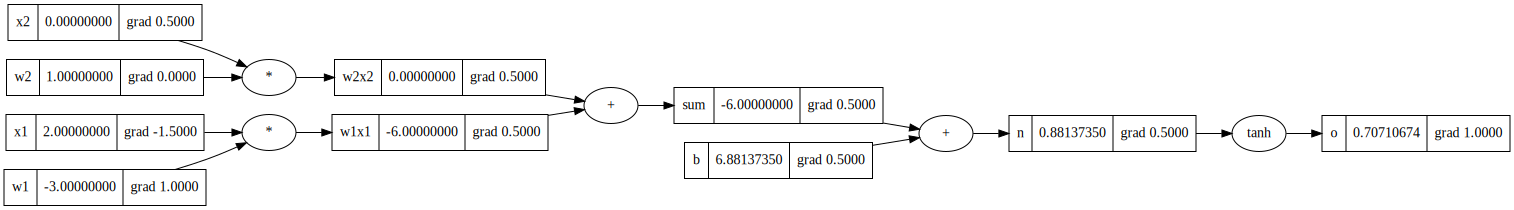

In [64]:
## Neuron model
# Inputs (axons)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights (synapses)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron (trigger-happiness)
b = Value(6.8813735, label='b')
# inputs * weigths (dendrites)
w1x1 = x1 * w1; w1x1.label = 'w1x1'
w2x2 = x2 * w2; w2x2.label = 'w2x2'
# Cell body
acc = w1x1 + w2x2; acc.label = 'sum'
n = acc + b; n.label = 'n'
o = n.tanh('o')

o.backward()
visualize_graph(o)

In [65]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---grads---")
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())


0.7071066904050358
---grads---
-1.5000003851533106
0.5000001283844369
1.0000002567688737
0.0


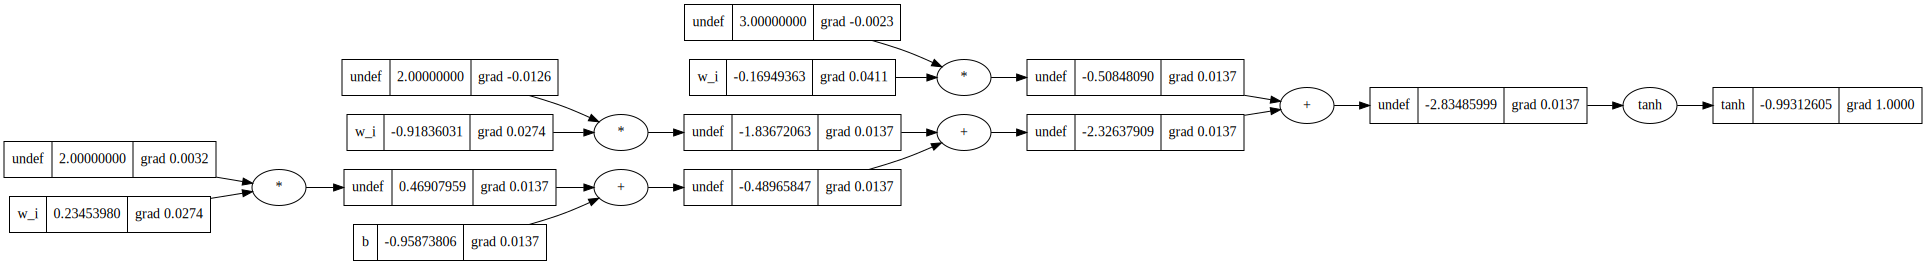

In [66]:
import random

class Neuron:
    # Initialize a Neuron with number of inputs to the neuron (see picture above).
    # For each input, create a random synapse strength (weight).
    # Create a random neuron bias.
    def __init__(self, n_inputs):
        self.w = [Value(random.uniform(-1,1), label='w_i') for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1,1), label='b')

    # Allows to call neuron object as a function.
    # When x is a vector of size 3 [x1, x2, x3], we zip it with array of weights [w1, w2, w3] into [(x1, w1)...]
    # Then, we calculate dot product of the result.
    def __call__(self, x):
        # w * x + b
        act = sum((w_i * x_i for w_i, x_i in zip(self.w, x)), self.b)
        return act.tanh()
    
    def get_parameters(self):
        return self.w + [self.b]

neuron = Neuron(3)
out = neuron([2.0, 2.0, 3.0])
out.backward()
visualize_graph(out)

In [67]:
from typing import List

class Layer:
    # Create a layer of neurons. A layer has N neurons and M inputs for each neuron.
    # Each M input is connected to every neuron.
    def __init__(self, n_inputs: int, n_neurons: int):
        self.neurons = [Neuron(n_inputs) for _ in  range(n_neurons)]

    # We call every neuron with the input.
    def __call__(self, x: List[float]):
        return [n(x) for n in self.neurons]
    
    def get_parameters(self):
        return [p for n in self.neurons for p in n.get_parameters()]
    
layer = Layer(n_inputs=3, n_neurons=4)
layer([3.0, 1.5, -2.0])

[Value(val=0.9894110442128115),
 Value(val=-0.9986698215783374),
 Value(val=-0.7789161886135394),
 Value(val=0.6605917967038953)]

### Multi-layer perceptron
A series of fully connected layers. In the first layer, every neuron is connected to every input. Every output of a previous layer is an input to next one. All the neurons in the next layer are also connected to all the outputs of the previous layer.

<img src="./multilayer-perceptron-1.png" width="60%" height="60%">

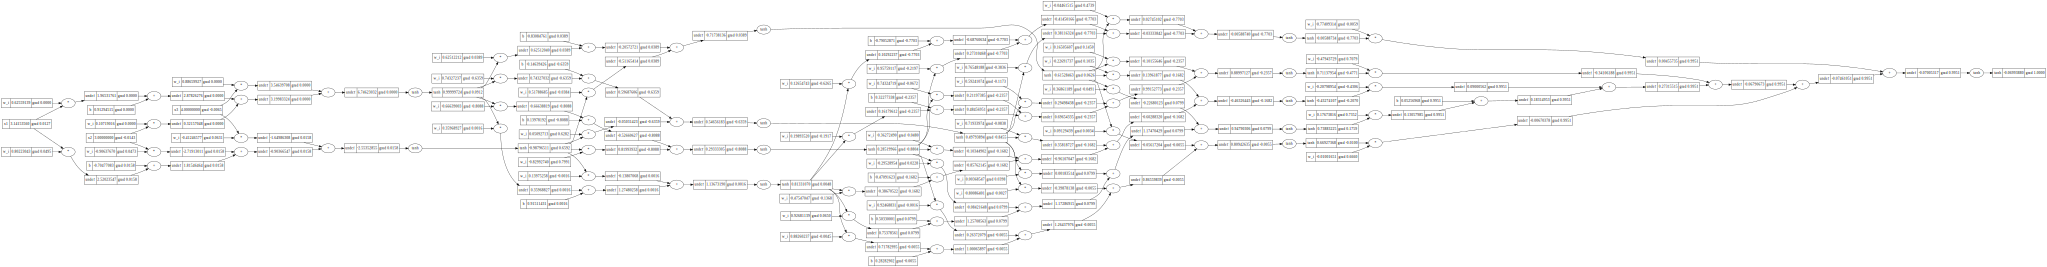

In [68]:
class MultiLayerPerceptron:
    # We create an MLP, which consists of K layers and has N inputs.
    def __init__(self, n_inputs: int, layer_sizes: List[int]):
        # This is an array of K+1 size, with size of each layer
        input_sizes = [n_inputs] + layer_sizes
        # Each layer has input_sizes[i] inputs and input_sizes[i+1] neurons. It has input_sizes[i+1] neurons, 
        # because each neuron has 1 output, and each output is an input to the new layer.
        self.layers = [Layer(input_sizes[i], input_sizes[i+1]) for i in range(len(layer_sizes))]

    def __call__(self, x):
        input = x
        for layer in self.layers:
            output = layer(input)
            input = output
        return output[0] if len(output) == 1 else output
    
    def get_parameters(self):
        return [p for layer in self.layers for p in layer.get_parameters()]
    
mlp = MultiLayerPerceptron(3, [2, 4, 5, 1])
x1, x2, x3, x4 = Value(3.1415356, label='x1'), Value(3.0, label='x2'), Value(4.0, label='x3'), Value(-1.0, label='x4')
out = mlp([x1, x2, x3, x4])
out.backward()
visualize_graph(out)

In [69]:
# Example dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    [4.0, 2.0, -3.0]
]
# Desired results (binary classifier)
ys = [1.0, -1.0, -1.0, 1.0, -1.0] 
mlp_outputs = [mlp(data_row) for data_row in xs]
results = list(zip(mlp_outputs, ys))
results

[(Value(val=-0.008868423370717304), 1.0),
 (Value(val=0.6489887102358897), -1.0),
 (Value(val=-0.029974261906553293), -1.0),
 (Value(val=0.3182457666102323), 1.0),
 (Value(val=0.6814416237855672), -1.0)]

In [70]:
# Inputs - mxn array, where m is data samples size, n is number of inputs to the first layer of network.
def get_loss(inputs, targets, mlp):
    mlp_outputs = [mlp(data_row) for data_row in inputs]
    losses = [(y_ground_truth - y_output)**2 for y_output, y_ground_truth in zip(mlp_outputs, targets)]
    loss = sum(losses)
    return loss

In [71]:
loss = get_loss(xs, ys, mlp)
loss.backward()
print("grad on W2 on first neuron in first layer", mlp.layers[0].neurons[0].w[2].grad)
mlp.layers[0].neurons[0].w[2].val += 1

new_loss = get_loss(xs, ys, mlp)
print("Old loss", loss, "New loss after increasing W2", new_loss)

grad on W2 on first neuron in first layer 0.6612726687707539
Old loss Value(val=7.96996396366719) New loss after increasing W2 Value(val=8.209434800164711)


## Neural network training
The below code iteratively runs the network to get the prediction on inputs (forward pass), calculates the gradient (backward pass) and updates the parameters according to the gradient values. A few iterations and that's it, the network is now able to classify the input data!

In [72]:
# Gradient descent
passes = 2048
step = -0.1
mlp = MultiLayerPerceptron(3, [3,4,1])
print("Starting loss", get_loss(xs, ys, mlp))
for i in range(1, passes):
    # Forward
    loss = get_loss(xs, ys, mlp)
    # We need to zero-grad, as the grads accumulate
    for param in mlp.get_parameters():
        param.grad = 0.0
    # Backward
    loss.backward()
    # Update
    for param in mlp.get_parameters():
        param.val += step * param.grad
    if (loss.val < 0.001):
        print("Loss is", loss.val, "after", i, "iterations, exiting.")
        break 
print(list(zip([mlp(x_row) for x_row in xs], ys)))

Starting loss Value(val=10.826147114906721)
Loss is 0.00099854035943668 after 478 iterations, exiting.
[(Value(val=0.9893592090978445), 1.0), (Value(val=-0.9998768222084974), -1.0), (Value(val=-0.9891387567939655), -1.0), (Value(val=0.9819422521357204), 1.0), (Value(val=-0.9790581070458755), -1.0)]
